# Model Time Series ML to predict metro frequentation during JO period but without JO of stations rattached to a site without known past events

In [1]:
# Dans ce notebook, on explore les données et on crée un premier modele de ML (fbProphet), sur les sites pour lequels on ne connait pas la fréquentation d'évènements passées.
# Les stations de métro concernées sont indiquées dans la liste stations_totales 2 cellules en dessous.
# Pour utiliser ce notebook, il suffit de mettre la station voulue, et exécuter tout le notebook.

In [2]:
station = "BERCY"

In [3]:
stations_totales = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL", "BOULEVARD VICTOR", "STADE DE FRANCE-SAINT-DENIS", "LA PLAINE-STADE DE FRANCE", 
                    "SAINT-DENIS-PORTE DE PARIS", "FRANKLIN-D.ROOSEVELT", "INVALIDES", "PALAIS ROYAL-MUSEE DU LOUVRE", "MADELEINE", "OPERA", "AUBER", 
                    "MUSEE D'ORSAY", "CHAMP DE MARS-TOUR EIFFEL", "LA MOTTE-PICQUET-GRENELLE", "SEGUR", "PONT DE L'ALMA", "BIR-HAKEIM (GRENELLE)", 
                    "ALMA-MARCEAU", "PORTE DE VERSAILLES", "BALARD", "PORTE DE VANVES", "PORTE DE LA CHAPELLE", "ROSA PARKS", "BERCY", "GARE DE LYON"]
stations_RG = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL"]
stations_PDP = ["PORTE DE SAINT-CLOUD", "PORTE D'AUTEUIL", "BOULEVARD VICTOR"]
stations_SDF = ["STADE DE FRANCE-SAINT-DENIS", "LA PLAINE-STADE DE FRANCE", "SAINT-DENIS-PORTE DE PARIS"]
stations_GP = ["FRANKLIN-D.ROOSEVELT"]
stations_INV = ["INVALIDES"]
stations_CCD = ["PALAIS ROYAL-MUSEE DU LOUVRE", "MADELEINE", "OPERA", "AUBER", "MUSEE D'ORSAY"]
stations_CDM = ["CHAMP DE MARS-TOUR EIFFEL", "LA MOTTE-PICQUET-GRENELLE", "SEGUR"]
stations_TEF = ["CHAMP DE MARS-TOUR EIFFEL", "PONT DE L'ALMA", "BIR-HAKEIM (GRENELLE)", "ALMA-MARCEAU"]
stations_SUD = ["PORTE DE VERSAILLES", "BALARD", "PORTE DE VANVES"]
stations_CHP = ["PORTE DE LA CHAPELLE", "ROSA PARKS"]
stations_BER = ["BERCY", "GARE DE LYON"]


In [4]:
#import librairies
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math
from prophet.utilities import regressor_coefficients


/Users/geoffrey_quillet/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#read all CSV
data = pd.read_csv("99-Data_Clean/data_concatenaited.csv")
data.head()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_57236/2921695896.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("99-Data_Clean/data_concatenaited.csv")


,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,lda
0,01/01/2015,100,110,1,PORTE MAILLOT,71379,AMETHYSTE,117,NaN
1,01/01/2015,100,110,1,PORTE MAILLOT,71379,AUTRE TITRE,37,NaN
2,01/01/2015,100,110,1,PORTE MAILLOT,71379,FGT,172,NaN
3,01/01/2015,100,110,1,PORTE MAILLOT,71379,IMAGINE R,605,NaN
4,01/01/2015,100,110,1,PORTE MAILLOT,71379,NAVIGO,2039,NaN


In [7]:
#Extract only informations about the two stations
mask = (data['LIBELLE_ARRET'] == station)
data = data.loc[mask]
data.head()

,JOUR,CODE_STIF_TRNS,CODE_STIF_RES,CODE_STIF_ARRET,LIBELLE_ARRET,ID_REFA_LDA,CATEGORIE_TITRE,NB_VALD,lda
1145,01/01/2015,100,110,66,BERCY,71607,AMETHYSTE,69,NaN
1146,01/01/2015,100,110,66,BERCY,71607,AUTRE TITRE,92,NaN
1147,01/01/2015,100,110,66,BERCY,71607,FGT,127,NaN
1148,01/01/2015,100,110,66,BERCY,71607,IMAGINE R,705,NaN
1149,01/01/2015,100,110,66,BERCY,71607,NAVIGO,1723,NaN


In [8]:
#Convert JOUR to datetime
data['JOUR'] = data['JOUR'].apply(lambda x: pd.to_datetime(x))

#Sort Values
data = data.sort_values(by='JOUR', ascending=True)

#Replace Moins de 5 par 5 dans NB_VALD
data['NB_VALD'] = data['NB_VALD'].apply(lambda x: 5 if x == 'Moins de 5' else x)

#Convert NB_VALD to integer
data['NB_VALD'] = data['NB_VALD'].apply(lambda x: int(x))

mask_years=(data['JOUR'].dt.year<2020)
data=data.loc[mask_years]

#Delete unuseful columns
data = data[['JOUR','NB_VALD']]

#GroupBy JOUR
data = data.groupby(['JOUR']).sum()
data = data.reset_index()

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_57236/1211621673.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['JOUR'] = data['JOUR'].apply(lambda x: pd.to_datetime(x))


In [9]:
data.describe(include='all')

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_57236/1336221646.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include='all')


,JOUR,NB_VALD
count,1825,1825.00000
unique,1825,NaN
top,2015-01-01 00:00:00,NaN
freq,1,NaN
first,2015-01-01 00:00:00,NaN
last,2019-12-31 00:00:00,NaN
mean,NaN,10765.06411
std,NaN,2836.11584
min,NaN,10.00000
25%,NaN,9127.00000


In [10]:
#Distribution
fig=px.line(data,x="JOUR",y='NB_VALD')#,color="LIBELLE_ARRET")
fig.show()

In [11]:
mean_data = data['NB_VALD'].mean()
std_data = data['NB_VALD'].std()
min_data = mean_data - (std_data * (1.5))
max_data = mean_data + (std_data * (1.5))
print(min_data)
print(max_data)
print(len(data.loc[data['NB_VALD'] < min_data]))
print(len(data.loc[data['NB_VALD'] > max_data]))

6510.890349604762
15019.237869573319
154
82


In [12]:
data['NB_VALD'] = [data['NB_VALD'][i] if (data['NB_VALD'][i] >= min_data)
                    else data['NB_VALD'][i-7] if ((data['NB_VALD'][i] < min_data) and (i > 6) and (data['NB_VALD'][i-7] > min_data))
                    else data['NB_VALD'][i-14] if ((data['NB_VALD'][i] < min_data) and (i > 13) and (data['NB_VALD'][i-7] < min_data) and (data['NB_VALD'][i-14] > min_data))
                    else data['NB_VALD'][i-21] if ((data['NB_VALD'][i] < min_data) and (i > 20) and (data['NB_VALD'][i-7] < min_data) and (data['NB_VALD'][i-14] < min_data) and (data['NB_VALD'][i-21] > min_data))
                    else (int(min_data) + 1)
                    for i in range(len(data['NB_VALD']))]
#data['NB_VALD'] = np.where(data['NB_VALD'] < min_data, data['NB_VALD'].shift(7), data['NB_VALD'])

In [13]:
data['NB_VALD'].loc[data['NB_VALD'] <= min_data+1]

0      6511
4      6511
7      6511
148    6511
155    6511
239    6511
246    6511
730    6511
Name: NB_VALD, dtype: int64

In [14]:
#Distribution
fig=px.line(data,x="JOUR",y='NB_VALD')#,color="LIBELLE_ARRET")
fig.show()

In [16]:
df_pdp = pd.read_csv("99-Data_Clean/df_pdp.csv")
df_pdp['datestamp'] = df_pdp['datestamp'].apply(lambda x: pd.to_datetime(x))
df_pdp.head()

,date,place,affluence,datestamp
0,So. 18.01.15,D,45561,2015-01-18
1,Mi. 21.01.15,D,40000,2015-01-21
2,Fr. 30.01.15,D,44955,2015-01-30
3,Mi. 11.02.15,D,35000,2015-02-11
4,Sa. 14.02.15,D,45571,2015-02-14


In [17]:
df_sdf = pd.read_csv("99-Data_Clean/df_sdf.csv")
df_sdf['datestamp'] = df_sdf['datestamp'].apply(lambda x: pd.to_datetime(x))
df_sdf.head()

,event_name,date,event_description,datestamp
0,La Voie Royale de Saint-Denis 2023,Dimanche 05 novembre 2023,NaN,2023-11-05
1,FRANCE vs AUSTRALIE 2023,Dimanche 27 août 2023,Match de préparation à la Coupe du Monde,2023-08-27
2,THE WEEKND 2 2023,Dimanche 30 juillet 2023,After Hours til Dawn,2023-07-30
3,THE WEEKND 2023,Samedi 29 juillet 2023,After Hours til Dawn,2023-07-29
4,Rammstein,Samedi 22 juillet 2023,NaN,2023-07-22


In [18]:
df_rg = pd.read_csv("99-Data_Clean/df_rg.csv")
df_rg['datestamp'] = df_rg['JOUR'].apply(lambda x: pd.to_datetime(x))
df_rg.head()

,JOUR,affluence,datestamp
0,2015-05-24,30522,2015-05-24
1,2015-05-25,34936,2015-05-25
2,2015-05-26,33732,2015-05-26
3,2015-05-27,34793,2015-05-27
4,2015-05-28,34915,2015-05-28


In [19]:
data.head()

,JOUR,NB_VALD
0,2015-01-01,6511
1,2015-01-02,7908
2,2015-01-03,6771
3,2015-01-04,12013
4,2015-01-05,6511


## SOME DATA VIZ

In [20]:
#Statistics
data.describe(include="all")

/var/folders/5n/p64q8ht13qzd7qbp48cbvk880000gn/T/ipykernel_57236/3692600302.py:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,JOUR,NB_VALD
count,1825,1825.000000
unique,1825,NaN
top,2015-01-01 00:00:00,NaN
freq,1,NaN
first,2015-01-01 00:00:00,NaN
last,2019-12-31 00:00:00,NaN
mean,NaN,11191.576986
std,NaN,2325.341556
min,NaN,6511.000000
25%,NaN,9757.000000


In [21]:
#Distribution
fig=px.histogram(data,x="NB_VALD")
fig.show()

In [22]:
#Distribution
fig=px.line(data,x="JOUR",y=('NB_VALD'))
fig.show()

In [23]:
##Check if all data is available

start_date = data['JOUR'].min()
end_date = data['JOUR'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Verify missing values
missing_dates = all_dates[~all_dates.isin(data['JOUR'])]

if len(missing_dates) == 0:
    print("Tous les jours sont présents dans le jeu de données.")
else:
    print("Il manque des jours dans le jeu de données.")
    print("Dates manquantes :", missing_dates)

Il manque des jours dans le jeu de données.
Dates manquantes : DatetimeIndex(['2015-03-22'], dtype='datetime64[ns]', freq='D')


In [24]:
len(missing_dates)

1

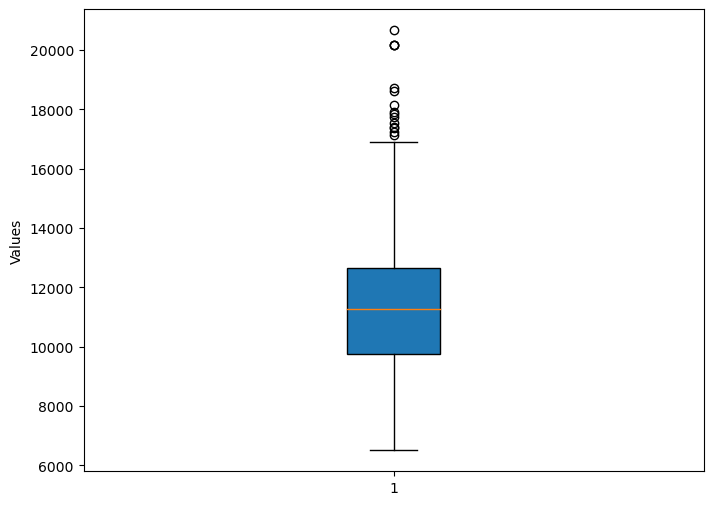

In [25]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['NB_VALD'],patch_artist=True)  # 'patch_artist=True' for filling the box

plt.ylabel('Values')
plt.show()

In [26]:
data.head()

,JOUR,NB_VALD
0,2015-01-01,6511
1,2015-01-02,7908
2,2015-01-03,6771
3,2015-01-04,12013
4,2015-01-05,6511


In [27]:
data['NB_VALD'] = np.log(data['NB_VALD'])

In [28]:
split_date='2019-01-01'
data_train = data.loc[data['JOUR'] < split_date].copy()
data_test = data.loc[data['JOUR'] >= split_date].copy()

In [29]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.rename(columns={'JOUR':'ds','NB_VALD':'y'})
data_train_prophet.head()

,ds,y
0,2015-01-01,8.781248
1,2015-01-02,8.975630
2,2015-01-03,8.820404
3,2015-01-04,9.393745
4,2015-01-05,8.781248


In [30]:
# Setup and train model and fit
model = Prophet(yearly_seasonality=True, weekly_seasonality=True,changepoint_prior_scale=0.5)
model.add_country_holidays(country_name='FR')
model.fit(data_train_prophet)

11:01:39 - cmdstanpy - INFO - Chain [1] start processing
11:01:40 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Predict on training set with model
data_test_prophet = data_test.rename(columns={'JOUR':'ds'})
data_test_fcst = model.predict(df=data_test_prophet)

In [32]:
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,9.331288,8.824950,9.271937,9.331288,9.331288,0.0,0.0,0.0,0.0,...,0.033180,0.033180,0.033180,-0.066427,-0.066427,-0.066427,0.0,0.0,0.0,9.055043
1,2019-01-02,9.331211,9.088461,9.536322,9.331211,9.331211,0.0,0.0,0.0,0.0,...,0.045044,0.045044,0.045044,-0.069756,-0.069756,-0.069756,0.0,0.0,0.0,9.306499
2,2019-01-03,9.331135,9.066152,9.551991,9.331135,9.331135,0.0,0.0,0.0,0.0,...,0.063552,0.063552,0.063552,-0.072204,-0.072204,-0.072204,0.0,0.0,0.0,9.322484
3,2019-01-04,9.331059,9.091375,9.560411,9.331059,9.331059,0.0,0.0,0.0,0.0,...,0.071671,0.071671,0.071671,-0.073719,-0.073719,-0.073719,0.0,0.0,0.0,9.329011
4,2019-01-05,9.330983,8.868422,9.307068,9.330983,9.330983,0.0,0.0,0.0,0.0,...,-0.174402,-0.174402,-0.174402,-0.074265,-0.074265,-0.074265,0.0,0.0,0.0,9.082317


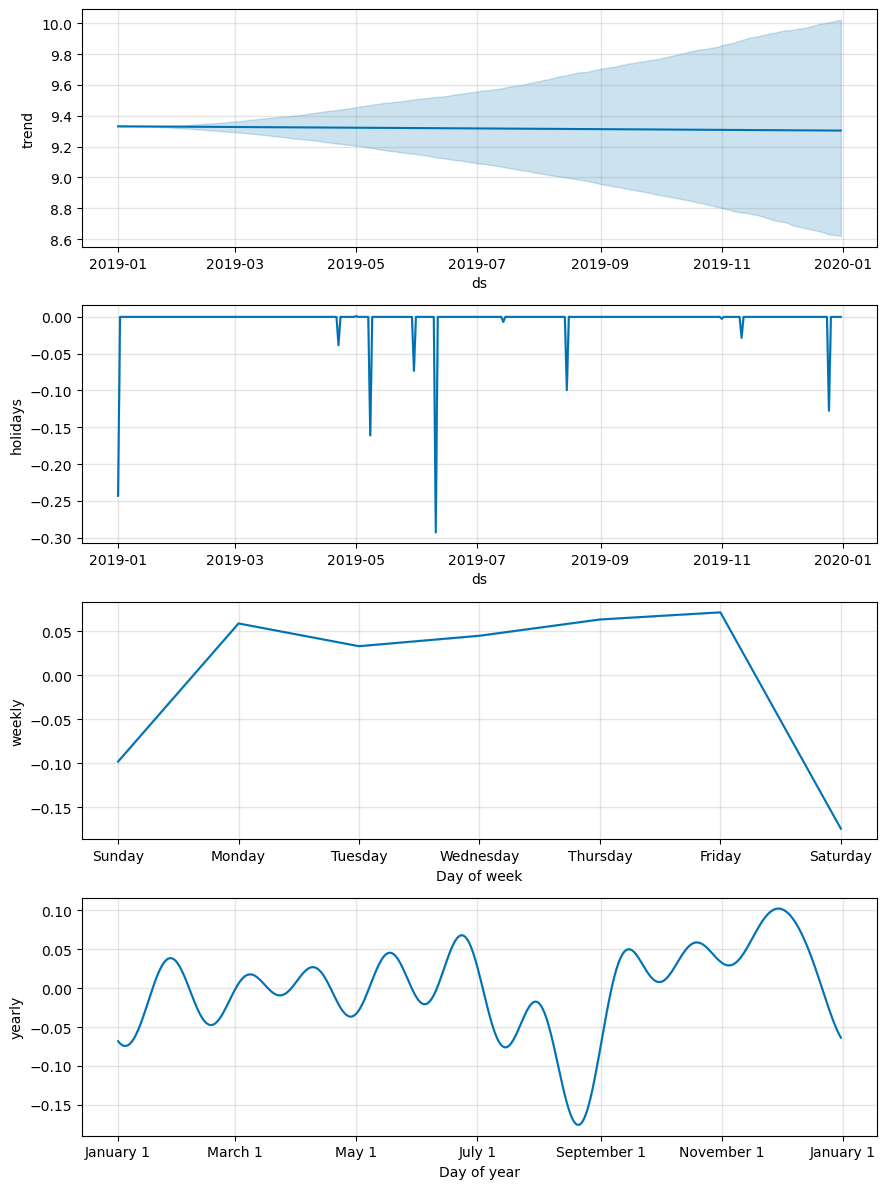

In [33]:
# Plot the components of the model
fig = model.plot_components(data_test_fcst)

In [34]:
fig = px.line(x = data_test['JOUR'], y = data_test['NB_VALD'])
fig.add_trace(px.line(data_test_fcst, x="ds", y="yhat").data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

In [35]:
mse = mean_squared_error(y_true=data_test['NB_VALD'],
                   y_pred=data_test_fcst['yhat'])

print("The MSE on the test set is : \n {}".format(mse))

The MSE on the test set is : 
 0.03940777806273655


In [36]:
mae = mean_absolute_error(y_true=data_test['NB_VALD'],
                   y_pred=data_test_fcst['yhat'])

print("The MAE on the test set is : \n {}".format(mae))

The MAE on the test set is : 
 0.157573587975094


In [37]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

mape = mean_absolute_percentage_error(y_true=data_test['NB_VALD'],
                   y_pred=data_test_fcst['yhat'])


print(f"La MAPE est : {mape:.2f}%")


La MAPE est : 1.68%


In [38]:
df_ssjo=pd.read_csv("99-Data_Clean/event_jo.csv")
df_ssjo=df_ssjo.iloc[:,0]
df_ssjo=pd.DataFrame(df_ssjo)
df_ssjo


,ds
0,2024-07-01
1,2024-07-02
2,2024-07-03
3,2024-07-04
4,2024-07-05
...,...
57,2024-08-27
58,2024-08-28
59,2024-08-29
60,2024-08-30


In [39]:
forecast = model.predict(df_ssjo)

In [40]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01,9.178458,9.051866,9.502191,9.178458,9.178458,0.0,0.0,0.0,0.0,...,0.059051,0.059051,0.059051,0.024258,0.024258,0.024258,0.0,0.0,0.0,9.261767
1,2024-07-02,9.178381,9.008628,9.460226,9.178381,9.178381,0.0,0.0,0.0,0.0,...,0.033180,0.033180,0.033180,0.014342,0.014342,0.014342,0.0,0.0,0.0,9.225904
2,2024-07-03,9.178305,8.993336,9.465990,9.178305,9.178305,0.0,0.0,0.0,0.0,...,0.045044,0.045044,0.045044,0.004034,0.004034,0.004034,0.0,0.0,0.0,9.227383
3,2024-07-04,9.178229,8.999217,9.484110,9.178229,9.178229,0.0,0.0,0.0,0.0,...,0.063552,0.063552,0.063552,-0.006442,-0.006442,-0.006442,0.0,0.0,0.0,9.235339
4,2024-07-05,9.178153,9.016422,9.466691,9.178153,9.178153,0.0,0.0,0.0,0.0,...,0.071671,0.071671,0.071671,-0.016857,-0.016857,-0.016857,0.0,0.0,0.0,9.232968


In [41]:
fig = px.line(x = forecast['ds'], y = np.exp(forecast['yhat']))

fig.show()

In [42]:
forecast=forecast[['ds', 'yhat']]
forecast['station']=station
forecast.to_csv(f"98-Forecast/forecast_ssjo_{station}.csv", index=False)